# Airbnb Data - EDA and data visualization with Matplotlib and Seaborn
## Introduction

This notebook performs basic EDA and data visualization (data viz) on a cleansed open-source Airbnb dataset from Kaggle. The goal is to extract meaningful insights for customers and Airbnb users.

The dataset includes listing-level information such as location, price, availability, and review activity.

🔗 Source of raw, uncleansed data: [Airbnb Open Data on Kaggle](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata)

Note: This is a personal data science project for educational purposes. To reproduce the results, please download the dataset directly from Kaggle and run it through my data cleansing notebook which you can find here: [Click here to view GitHub cleansing repo](https://github.com/mg-ds-portfolio/prj_open_airbnb_data_cleanse.git)

---

## Setup, Data Import and Check

In [45]:
# Import packages.
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

In [82]:
# Configure chart displays and float display.

# Allow in-line plotting.
%matplotlib inline

# Set plot style.
plt.style.use("seaborn-v0_8-whitegrid")

In [47]:
# import raw data and take a copy to work on.
df_raw = pd.read_csv("/home/mark/data_viz_practice/prj_open_airbnb_data_viz/data/airbnb_open_data_cleaned.csv")
df = df_raw.copy()

In [48]:
# Inspect data.
df.head()

,id,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
0,1001254,brooklyn,kensington,40.64749,-73.97237,False,strict,private room,2020.0,966.0,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0
1,1002102,manhattan,midtown,40.75362,-73.98377,False,moderate,entire home/apt,2007.0,142.0,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0
2,1002403,manhattan,harlem,40.80902,-73.94190,True,flexible,private room,2005.0,620.0,124.0,3.0,0.0,NaN,0.00,5.0,1.0,352.0
3,1002755,brooklyn,clinton hill,40.68514,-73.95976,True,moderate,entire home/apt,2005.0,368.0,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0
4,1003689,manhattan,east harlem,40.79851,-73.94399,False,moderate,entire home/apt,2009.0,204.0,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0


In [49]:
# Check data types, NAs, and number of unique values (to identify candidates for categorical data type).
dtype_df = pd.DataFrame({
    "data type": df.dtypes,
    "na_count": df.isna().sum(),
    "num_unique_values": df.nunique()
})

dtype_df

,data type,na_count,num_unique_values
id,int64,0,99812
neighbourhood_group,object,0,5
neighbourhood,object,0,224
lat,float64,0,21846
long,float64,0,17643
instant_bookable,bool,0,2
cancellation_policy,object,0,3
room_type,object,0,4
construction_year,float64,0,20
price,float64,0,1151


Observations:
- The only column with NAs is last_review. All others have been dropped or filled.
- Data types broadly align with content (int/float for numbers, object for strings).

Actions:
- Convert data to int/float/category/string/datetime.
- Perform basic checks to make sure conversion happened correctly.

In [50]:
# Convert columns to correct data type.

category_type_cols = ["neighbourhood_group", "instant_bookable", "construction_year", "cancellation_policy", "room_type"]
numeric_type_cols = ["id", "lat", "long", "price", "service_fee", "minimum_nights", "number_of_reviews", "reviews_per_month", "review_rate_number", "calculated_host_listings_count", "availability_365"]
string_type_cols = ["neighbourhood"]
datetime_type_cols = ["last_review"]

for col in category_type_cols:
    df[col] = df[col].astype("category")

for col in numeric_type_cols:
    df[col] = pd.to_numeric(df[col])

for col in string_type_cols:
    df[col] = df[col].astype("string")

for col in datetime_type_cols:
    df[col] = pd.to_datetime(df[col])

print("Conversion check:")
print("----------")
print(f"Category columns: {len(category_type_cols)}")
print(f"Numeric columns: {len(numeric_type_cols)}")
print(f"String columns: {len(string_type_cols)}")
print(f"Datetime columns: {len(datetime_type_cols)}")
print("----------")
print(f"Total # cols converted: {len(category_type_cols) + len(numeric_type_cols) + len(string_type_cols) + len(datetime_type_cols)}")

print(f"df width: {len(df.columns)}")

print("\n")

print(df.dtypes)

Conversion check:
----------
Category columns: 5
Numeric columns: 11
String columns: 1
Datetime columns: 1
----------
Total # cols converted: 18
df width: 18


id                                         int64
neighbourhood_group                     category
neighbourhood                     string[python]
lat                                      float64
long                                     float64
instant_bookable                        category
cancellation_policy                     category
room_type                               category
construction_year                       category
price                                    float64
service_fee                              float64
minimum_nights                           float64
number_of_reviews                        float64
last_review                       datetime64[ns]
reviews_per_month                        float64
review_rate_number                       float64
calculated_host_listings_count           float64
availab

Notes on conversion:
- review_rate_number left as float (rather than category) so we can perform numerical calculations on data later.

---
# EDA and Data Viz

## Goal Setting

What useful information can we extract from this information? Let's look at it from 2 different perspectives - that of a customer, and that of an Airbnb owner.

Customer POV questions:
- Where will I find the best deal (highest rating for the lowest price)?
    - Where are the properties located? In which neighbourhood will I have the most options?
    - In general, where are the best rated properties? How can I narrow my search?
    - Are higher rated properties generally more expensive?

Owner questions:
- How can I make more money from my listing?
    - What features do more expensive listings have that I could replicate to justify charging more?
    - How can I increase the number of bookings?
        - If we assume number of reviews is indicative of number of bookings, what features do highly reviewed listings have?
    - Can I charge higher service fees?

## Plotting method summary
To create graphs in Matplotlib or Seaborn, follow the same 5 steps:
1. Prepare the data
2. Create the figure and axes
3. Create the plot
4. Format plot elements
5. Show the plot

---

## Customer-focused EDA/Viz

In [51]:
# How many properties do we have in each neighbourhood_group?

# Step 1. Prepare the data
properties_per_ngroup = df["neighbourhood_group"].value_counts()
properties_per_ngroup

neighbourhood_group
manhattan        42588
brooklyn         40737
queens           12925
bronx             2632
staten island      930
Name: count, dtype: int64

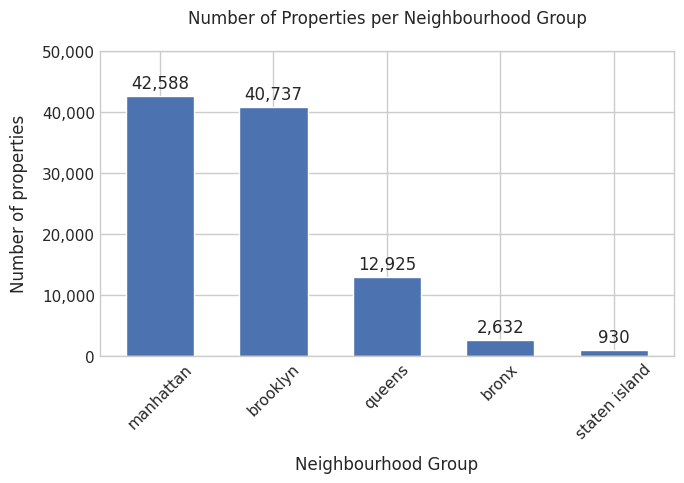

In [83]:
# Step 2. Create the figure and axes
fig, ax = plt.subplots(figsize = (7,5))

# Step 3. Create the plot
ax.bar(properties_per_ngroup.index, properties_per_ngroup.values, width = 0.6)

# Step 4. Format plot elements
ax.set_title("Number of Properties per Neighbourhood Group", pad = 20)

ax.set_xlabel("Neighbourhood Group", labelpad = 10)
ax.set_ylabel("Number of properties", labelpad = 10)


ax.set_ylim(0, 50000)
ax.tick_params(axis = "x", rotation = 45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Add labels
for container in ax.containers:
    ax.bar_label(
        container, 
        labels = [f"{int(v.get_height()):,}" for v in container], 
        padding=3)

# Step 5. Show plot
plt.tight_layout()
plt.show()

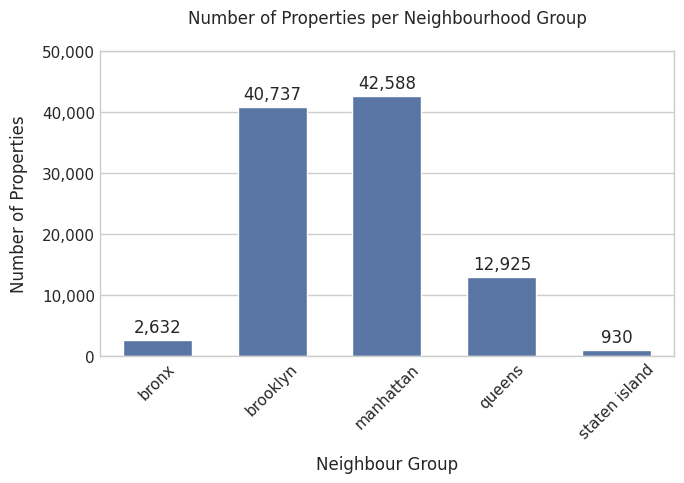

In [84]:
# Let's recreate the same chart using Seaborn.

# Step 1. Prepare the data
# Seaborn has a built in bar chart for counts, the countplot, so no need to prep the data.

#Step 2. Create figure and axes
fig, ax = plt.subplots(figsize = (7,5))

# Step 3. Create the plot
sns.countplot(
    ax = ax,
    data = df, 
    x = "neighbourhood_group",
    width = 0.6)

# Step 4. Formatting
ax.set_title("Number of Properties per Neighbourhood Group", pad = 20)
ax.set_xlabel("Neighbour Group", labelpad = 10)
ax.set_ylabel("Number of Properties", labelpad = 10)
ax.set_ylim(0, 50000)
ax.tick_params(axis = "x", rotation = 45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Add labels
for container in ax.containers:
    ax.bar_label(
        container, 
        labels = [f"{int(v.get_height()):,}" for v in container], 
        padding=3)

# Step 5. Show plot
plt.tight_layout()
plt.show()


Observations:
- As expected, there are significantly more properties for rent in Manhattan and Brooklyn.

Let's plot the properties using lat and long. 

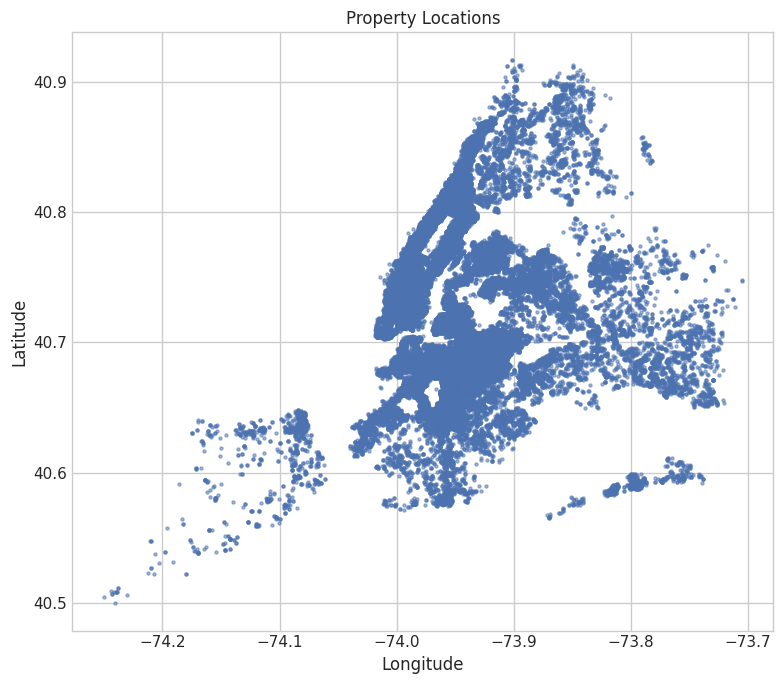

In [85]:
# Step 1. Prepare the data.
# There's no need to prep data. We can map property location using lat and long.

# Step 2. Create fig and axes
fig, ax = plt.subplots(figsize = (8,7))

# Step 3. Create the plot
ax.scatter(
    x = df["long"], 
    y = df["lat"], 
    s = 5, 
    alpha = 0.5)

# Step 4. Format
ax.set_title("Property Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# Step 5. Show plot
plt.tight_layout()
plt.show()

This isn't very helpful on it's own. It essentially recreates a map of New York.

It might be interesting to see on this pseudo-map how other facets of the data vary. Let's create the same map in Seaborn but use hue to represent different property features.

Note: You can use size or style to represent other data fields, but with so many data points (~100k) it becomes difficult to spot differences in either size or marker style.

Since we're basically creating the same map multiple times with small tweaks, we use loops to generate multiple subplots at once.

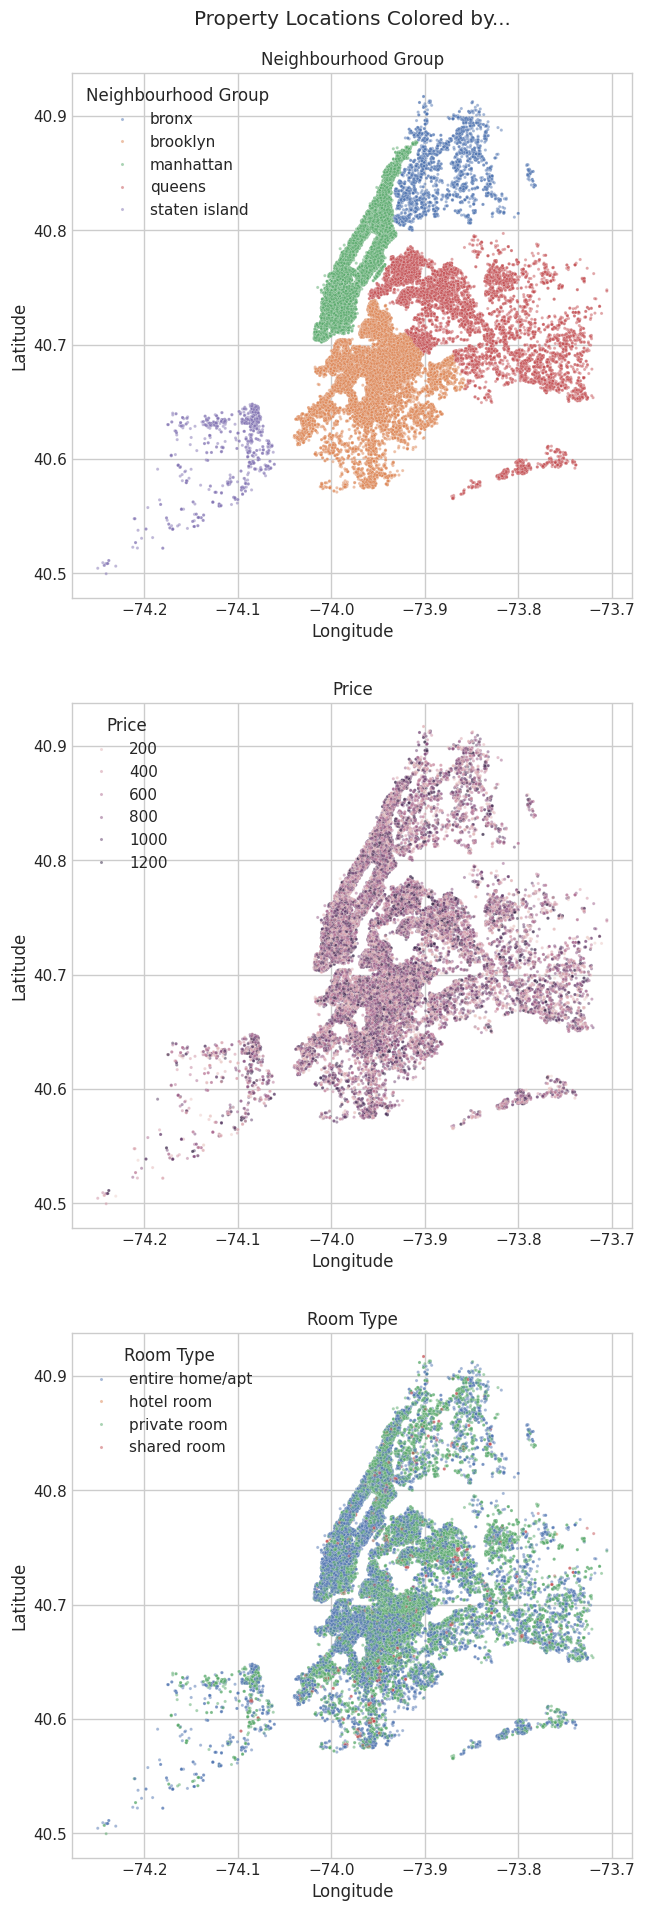

In [86]:
# Step 1. Prepare the data. Set which columns hue will represent.
scatter_subplot_hue_data = ["neighbourhood_group", "price", "room_type"]

# Step 2. Create fig and grid of axes
fig, axs = plt.subplots(3,1, figsize = (7,21))
fig.subplots_adjust(top=0.95)

# Combine steps 3 and 4 - we're looping over each subplot. It's more efficient to create and format each plot in one go.
# Loop over all axes
for i, ax in enumerate(axs.flat):
    # Create subplots
    if i >= len(scatter_subplot_hue_data):
        break
    else:
        sns.scatterplot(
            ax = ax,
            data = df,
            x = "long", 
            y = "lat", 
            s = 5, 
            alpha = 0.5, 
            hue = scatter_subplot_hue_data[i]
        )
    
    # Format subplots
    ax.grid(True)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{scatter_subplot_hue_data[i].replace("_", " ").title()}")
    
    # Format legends
    legend = ax.legend()
    legend.set_title(f"{scatter_subplot_hue_data[i].replace("_", " ").title()}")
    legend.set_loc("upper left")

# Set title for grid of subplots
fig.suptitle("Property Locations Colored by...")

plt.subplots_adjust(
    left=0.1, 
    right=0.9,
    bottom=0.1,
    top=0.95,
    hspace=0.2
)

# Step 5. Show plot
plt.show()

Observations:
- With so many data points, we're not learning much from the scatter plots.
- The prices seem fairly evenly distributed across the neighbourhood groups. I was expecting more of a concentration of higher prices in Manhattan and Brooklyn but that doesn't seem to be a significant visual trend.

**Possilbe improvements to these plots**

If we were publishing these plots in a report or wanted to improve the code, there are some improvements we could make, that weren't essential for this quick analysis.

- Make the legend markers larger. 
- Make the plots overlay a map of New York.
- Dynamically create the size of the figure based on the number of "hue" variables being inspected.

Let's see which neighbourhood has the highest rated properties:

In [56]:
# Step 1. Prep the data
avg_rating_by_nhood_grp = df.groupby("neighbourhood_group", observed = True)["review_rate_number"].mean().sort_values(ascending = False)
avg_rating_by_nhood_grp

neighbourhood_group
staten island    3.401075
bronx            3.329787
queens           3.327118
manhattan        3.278647
brooklyn         3.259518
Name: review_rate_number, dtype: float64

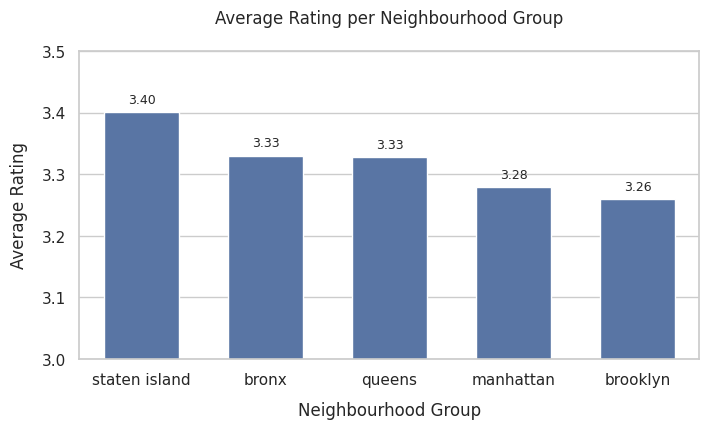

In [57]:
# Step 2. Create fig and ax
fig, ax = plt.subplots(figsize = (8, 4))

# Step 3. Create plot
sns.barplot(
    x = avg_rating_by_nhood_grp.index, 
    y = avg_rating_by_nhood_grp.values, 
    ax = ax, 
    order = avg_rating_by_nhood_grp.index, 
    width = 0.6)

# Step 4. Format
ax.set_title("Average Rating per Neighbourhood Group", pad = 20)
ax.set_xlabel("Neighbourhood Group", labelpad = 10)
ax.set_ylabel("Average Rating", labelpad = 10)
ax.set_ylim(3,3.5)

for i, v in enumerate(avg_rating_by_nhood_grp.values):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

# Step 5. Show plot
plt.show()

Observation:
- The means are quite similar. We don't learn a lot about which neighbourhood group might have overall better properties.

Action:
- Create plots to see distribution of ratings per neighbourhood group. Because there are so few categories, a box plot will probably not reveal much (min, Q1, median, Q3 and max will likely be 1, 2, 3, 4 and 5 respectively) so let's create a count plot.

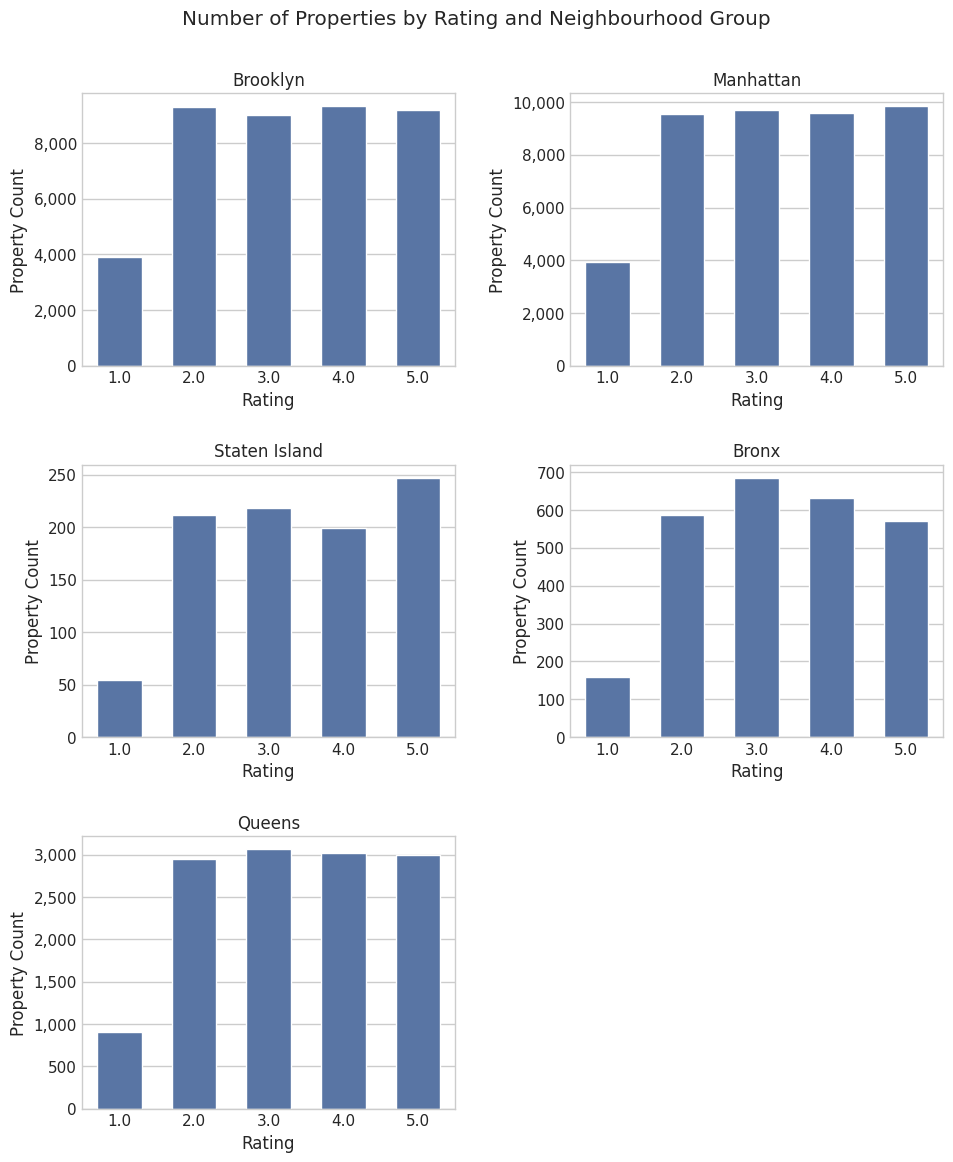

In [93]:
# Step 1. Prepare data
nhood_groups = df["neighbourhood_group"].unique()

# Step 2. Create fig and axs
fig, axs = plt.subplots(3, 2, figsize = (10,12))

# Step 3 and 4. Create and format
for nhood_group, ax in zip(nhood_groups, axs.flat):
    # Create subplots
    sns.countplot(
        ax = ax,
        data = df[df["neighbourhood_group"] == nhood_group],
        x = "review_rate_number",
        width = 0.6
    )
    ax.set_title(nhood_group.title())
    ax.set_xlabel("Rating")
    ax.set_ylabel("Property Count")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

fig.suptitle("Number of Properties by Rating and Neighbourhood Group")

# Step 5. Show plot. We'll also tidy up unused plots
for ax in axs.flat[len(nhood_groups):]:
    ax.axis("off")

plt.tight_layout(pad = 2)
plt.show()



Observation:
- Although not the prettiest plots, this reveals something unexpected. They show that there is a roughly even distribution of properties with ratings between 2 and 5. I was expecting a more pronounced version of the plot for the Bronx, with a peak at 3.
- The relatively low number of 1-star reviews is expected. It would be difficult for properties with one star to survive when there are so many better options.

Conclusion:
- There is no neighbourhood group that has a greater ratio of highly-rated properties. 

Next steps:
- We might assume that rating, neighbourhood group or room type would have an effect on price. Let's check using boxplots.

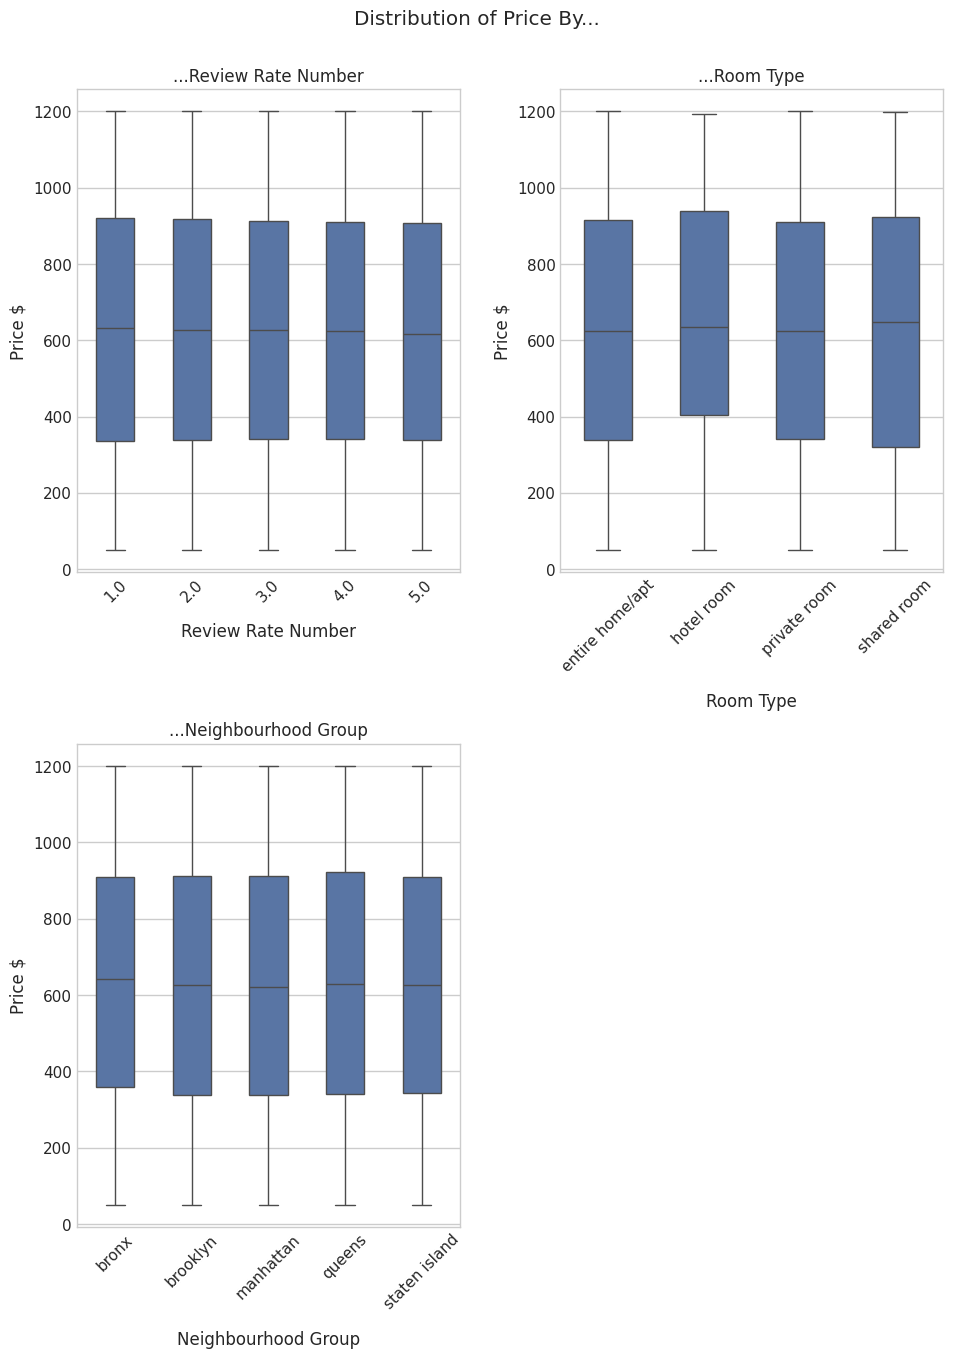

In [97]:
fig, axs = plt.subplots(2,2, figsize = (10,14))

prop_features = ["review_rate_number", "room_type", "neighbourhood_group"]

for i, ax in enumerate(axs.flat):
    if i >= len(prop_features):
        break
    else:
        sns.boxplot(
            ax = ax,
            data = df,
            y = "price",
            x = prop_features[i],
            width = 0.5
        )
        ax.set_title(f"...{prop_features[i].replace("_", " ").title()}")
        ax.set_ylabel("Price $")
        ax.set_xlabel(f"{prop_features[i].replace("_", " ").title()}", labelpad=13)
        ax.tick_params(axis = "x", rotation = 45)

fig.suptitle("Distribution of Price By...")
#fig.align_xlabels()

for ax in axs.flat[len(prop_features):]:
    ax.axis("off")

plt.tight_layout(pad = 2)
plt.show()

Observations:
- The distributions of price by review rate number are almost identical. This means that the average 1-star property costs the same as the average 5-star property.
- The distributions of price by room type vary very slightly, notably that hotel room prices are more tightly clustered when below the median.
- The distributions of price by neighbourhood group are also very similar, both to each other and (by visual inspection) and to other variables.

Conclusion:
- This is unexpected. It seems counterintuitive that neither rating, neighburhood group nor (albeit to a slightly lesser extent) room type would have a discernible effect on price.
- If this data was accurate, customers should only ever book 5-star rated properties in whichever neighbourhood group is their preference.
- They should also know that they are less likely to find a really cheap hotel room compared to other room types.

Next steps:
- Since we know that prices on average are distributed similarly across neighbourhood groups, the last thing we'll do from a customer POV is to check the mean price of a room in each neighbourhood and see where we can find the best prices.

In [60]:
avg_stats_per_nhood = (
    df.groupby(["neighbourhood", "neighbourhood_group"], observed = True)
    .agg({
        "price": "mean",
        "review_rate_number": "mean",
        "id": "count"
    })
    .sort_values("price", ascending = False)
    .reset_index()
)
avg_stats_per_nhood[["price", "review_rate_number"]] = avg_stats_per_nhood[["price", "review_rate_number"]].round(2)
avg_stats_per_nhood.columns = ["Neighbourhood", "Neighbourhood Group", "Average Price $", "Average Rating", "Property Count"]

avg_stats_per_nhood

,Neighbourhood,Neighbourhood Group,Average Price $,Average Rating,Property Count
0,new dorp,staten island,1045.00,3.25,4
1,"chelsea, staten island",staten island,1042.00,2.00,1
2,fort wadsworth,staten island,1024.00,2.00,2
3,little neck,queens,817.75,3.88,8
4,jamaica hills,queens,812.90,2.67,21
...,...,...,...,...,...
219,richmondtown,staten island,373.40,3.20,5
220,spuyten duyvil,bronx,314.12,3.00,8
221,breezy point,queens,309.89,3.11,9
222,rossville,staten island,300.67,3.00,3


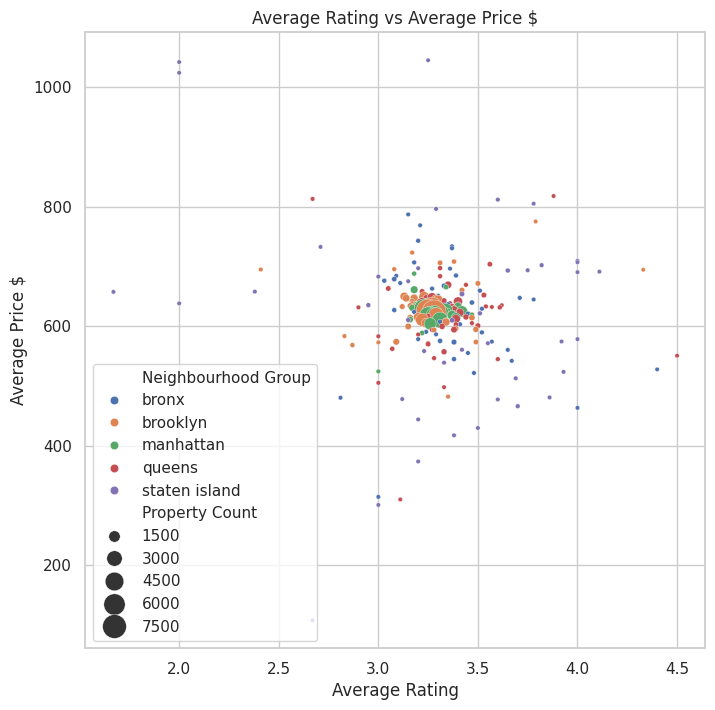

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))

sns.scatterplot(
    ax = ax,
    data = avg_stats_per_nhood,
    x = "Average Rating",
    y = "Average Price $",
    size = "Property Count",
    sizes = (10,300),
    hue = "Neighbourhood Group"
)

ax.legend(
    loc = "lower left", 
    frameon = True)

ax.set_title("Average Rating vs Average Price $")
plt.show()

Observations:
- There are some neighbourhoods with significantly more properties than others, which heavily skews the average cost and average rating.
- There are some neighbourhoods which are a "better deal" than others, i.e. their average cost is lower for the same rating, or their average rating is higher for the same price.

Improvements to the plot:
- If we draw a horizontal line through the average price for all properties, and a vertical line through the average rating for all properties, we will divide the plot into 4 quarters:
    - neighbourhoods in the top left quarter are a "bad deal", i.e. the price is higher for a lower rating.
    - neighbourhoods in the top right quarter or the bottom left quarter are an "OK deal", i.e. if you've paid more than average you've gotten a higher rating than average, and vice versa (if you paid less, you got a lower rating).
    - neighbourhoods in the bottom right quarter are a "good deal", i.e. you can pay a less than average price for a higher than average rating.
- Let's add the horizontal and vertical lines to the original plot to show our logic, then crate a plot that focuses on the lower right quarter.
- For that second plot, we'll exclude neighbourhoods with low numbers of properties.

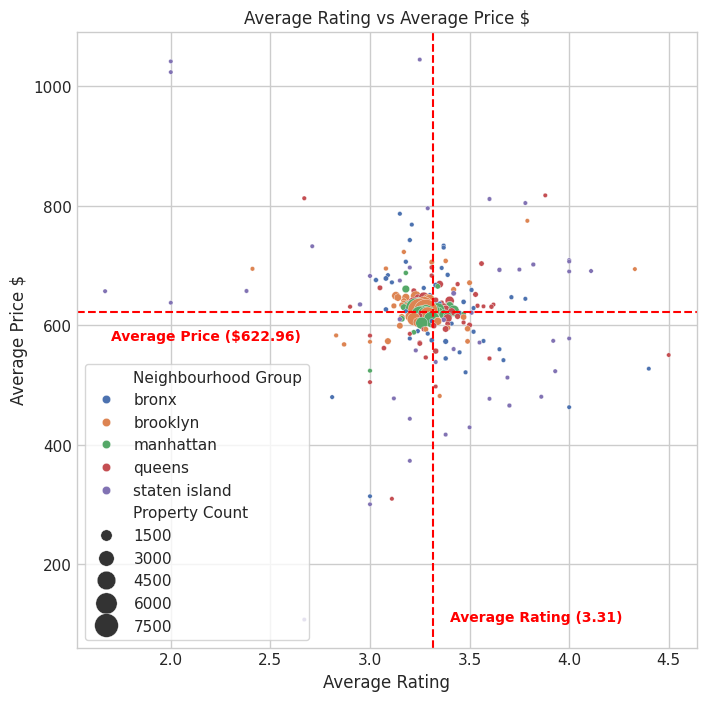

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))

sns.scatterplot(
    ax = ax,
    data = avg_stats_per_nhood,
    x = "Average Rating",
    y = "Average Price $",
    size = "Property Count",
    sizes = (10,300),
    hue = "Neighbourhood Group"
)
ax.axhline(y = avg_stats_per_nhood["Average Price $"].mean(), color = "red", linestyle = "--")
ax.axvline(x = avg_stats_per_nhood["Average Rating"].mean(), color = "red", linestyle = "--")

ax.text(
    x = 3.4, 
    y = 100, 
    s = f"Average Rating ({avg_stats_per_nhood["Average Rating"].mean().round(2)})", 
    fontsize = 10,
    weight = "bold",
    color = "red",
    ha = "left",
    va = "bottom",
    )

ax.text(
    x = 1.7, 
    y = 570, 
    s = f"Average Price (${avg_stats_per_nhood["Average Price $"].mean().round(2)})", 
    fontsize = 10,
    weight = "bold",
    color = "red",
    ha = "left",
    va = "bottom",
    )

ax.legend(
    loc = "lower left", 
    frameon = True)

ax.set_title("Average Rating vs Average Price $")
plt.show()

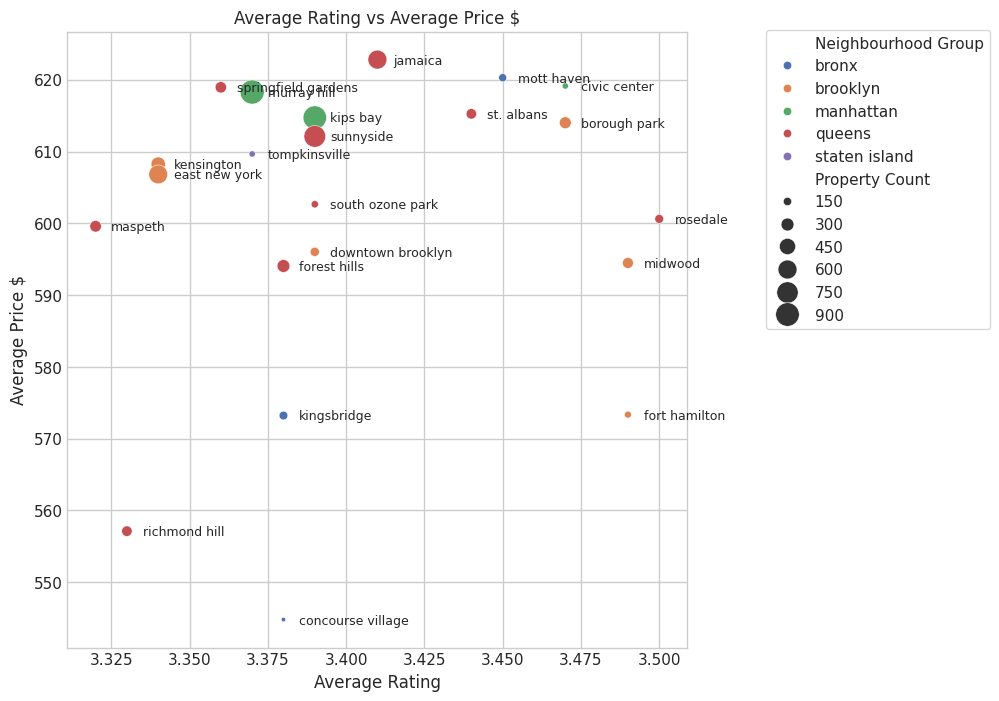

In [128]:
prop_count_cutoff = 50

avg_stats_per_nhood_filtered = avg_stats_per_nhood[
    (avg_stats_per_nhood["Average Rating"] >= avg_stats_per_nhood["Average Rating"].mean()) &
    (avg_stats_per_nhood["Average Price $"] <= avg_stats_per_nhood["Average Price $"].mean())
    & (avg_stats_per_nhood["Property Count"] >= prop_count_cutoff)
]
fig, ax = plt.subplots(figsize = (8,8))

sns.scatterplot(
    ax = ax,
    data = avg_stats_per_nhood_filtered,
    x = "Average Rating",
    y = "Average Price $",
    size = "Property Count",
    sizes = (10,300),
    hue = "Neighbourhood Group"
)

for i, row in avg_stats_per_nhood_filtered.iterrows():
    ax.text(
        x = row["Average Rating"] + 0.005,
        y = row["Average Price $"] - 1,
        s = str(row["Neighbourhood"]),
        ha="left",
        va="bottom",
        fontsize=9
    )

ax.legend(
    bbox_to_anchor=(1.5, 1.015), 
    loc = "upper right", 
    frameon = True)

ax.set_title("Average Rating vs Average Price $")
plt.show()

Final Conclusions:
- Customers looking for a good deal, i.e. a higher-than-average rated property for a lower-than-average price, should look in one of the neighbourhoods labelled above.
- They should look for 4 or 5-star rated properties because they are not guaranteed to find a lower price for a lower rating.
---

## Owner-focused EDA/Viz

In general, the features we've observed so far contradict what I considered to be our safest assumption, i.e. that more highly rated properties can and will charge more. This could imply that the data is fabricated, in which case it's unlikley we'll gain any valuable insights from an owners perspective, but let's check.

We'll start by seeing if features of our property that are easy to change (instant_bookable and cancellation_policy) can be used to justify a higher price.

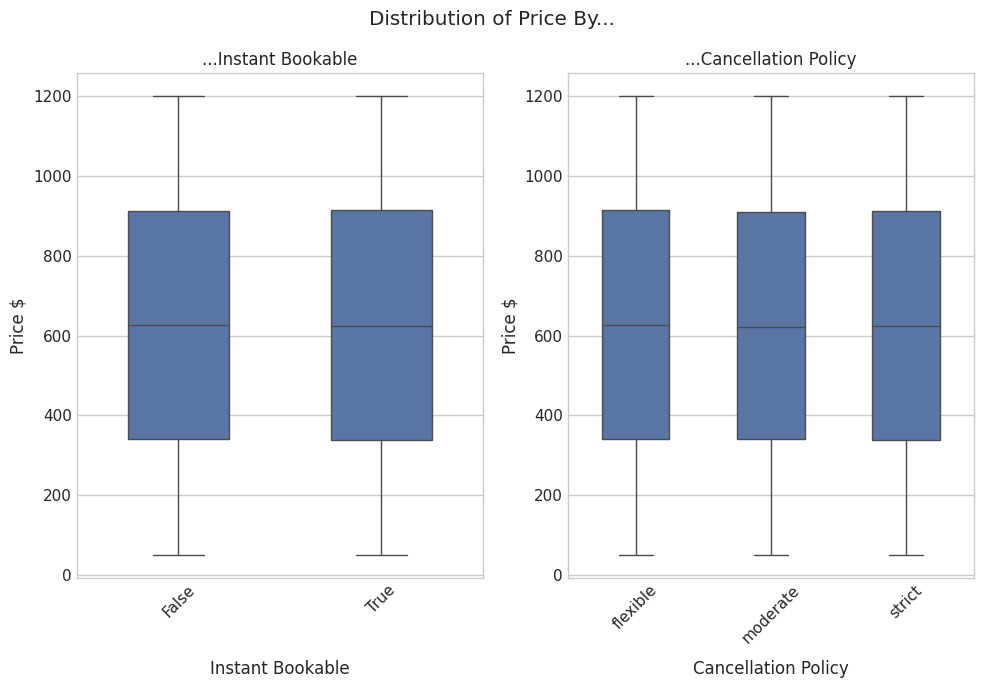

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10,7))

prop_features = ["instant_bookable", "cancellation_policy"]

for i, ax in enumerate(axs.flat):
    sns.boxplot(
        ax = ax,
        data = df,
        y = "price",
        x = prop_features[i],
        width = 0.5
    )
    ax.set_title(f"...{prop_features[i].replace("_", " ").title()}")
    ax.set_ylabel("Price $")
    ax.set_xlabel(f"{prop_features[i].replace("_", " ").title()}", labelpad = 10)
    ax.tick_params(axis = "x", rotation = 45)

fig.suptitle("Distribution of Price By...")
fig.align_xlabels()

plt.subplots_adjust(
    left=0.1, 
    right=0.9,
    bottom=0.1,
    top=0.95,
    hspace=0.2,
    wspace = 0.2
)
plt.tight_layout()
plt.show()

Observations:
- This is extremely similar to the distribution of prices by review rating, which implies that none of the features we've inspected so far have any effect on price.

Action:
- Let's see which, if any, of the numerical property features are correlated

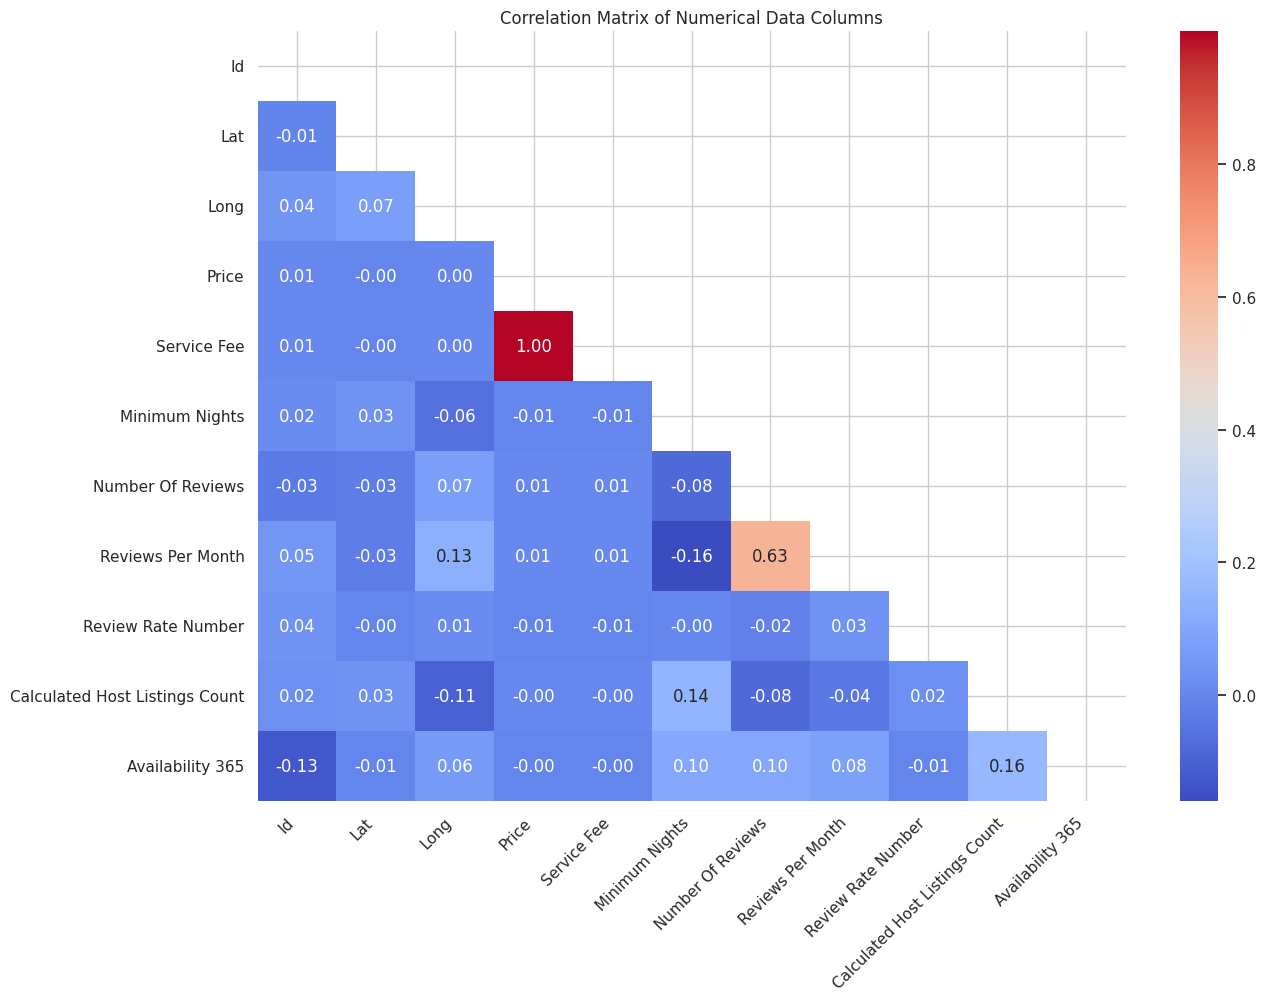

In [66]:
# Step 1. Prepare the data
# Select only numerical columns
numerical_cols = df.select_dtypes(include = ["int64", "float64"]).columns
clean_labels = [label.replace("_", " ").title() for label in numerical_cols]

# Create correlation matrix
correlation_matrix = df[numerical_cols].corr(method = "pearson")

# Getting the Upper Triangle of the co-relation matrix
corr_matrix_mask = np.triu(correlation_matrix)

# Steps 2-5 as normal.
fig, ax = plt.subplots(figsize = (14,10))

sns.heatmap(
    ax = ax,
    data = correlation_matrix,
    mask = corr_matrix_mask,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f"
)
ax.set_xticklabels(clean_labels, rotation = 45, ha = "right")
ax.set_yticklabels(clean_labels)
ax.set_title("Correlation Matrix of Numerical Data Columns")

plt.show()

Observations:
- service_fee and price are perfectly correlated (service fee is a % of price).
- reviews_per_month is strongly correlated with number_of_reviews, which is logical.
- All other correlations are weak.

---

## Final Conclusions

This data help some surprises. As a guest and as an owner, price is probably the most significant factor of interest, but this data shows that the price does not vary in the ways we might expect:
- The distribution of prices does not vary by rating or neighbourhood group.
- There was some variation in price by neighbourhood.
- There was some variation in price by room type, but only for hotel rooms.

We also saw in the data that there were very similar numbers of properties with 2, 3, 4 and 5-star ratings. I was expecting to see the fewest properties having 1 star (which we did), increasing in number up to 3-star and then a decrease for 4 and 5-stars.

The data came from a public source on Kaggle. It's authenticity could not be verified. But this was an exercise in EDA and data viz, and for that this made for an interesting exercise.